### Imports

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import re
import nltk
import logging

import spacy
import en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
import gensim
from gensim.utils import lemmatize 
from nltk.stem import WordNetLemmatizer 

from sklearn import feature_extraction
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (plot_roc_curve, classification_report, roc_auc_score, average_precision_score,
confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve)


### Configs

In [2]:
configs = {
    "run_name": "template_run",
    "test_year": 2020,
    # Model Type, will support LR, SVC, RandomForest, and NB
    'model': 'svc', # lr, svc, mnb, bnb, rf 
    'upsampling': 0.4, # 0.0 to 1.0 or None
    'lemmatize': None, #'spacy', # Choose from nltk, spacy, gensim, None
    # Vectorizer Type (CV, TFIDF)
    'vectorizer': {'type': 'cv', 
                    'ngrams': (1,3),
                   'binary': True,
                   'stopwords': 'english',
                   'max_df': 0.8,
                   'min_df': 10,
                  },
    'grid_search': True, # If true, your other hyperparemeters should be in a list.
    'hyperparameters': {
        # Change these based on your model.
        "C": [1]
    }
}

configs

{'run_name': 'template_run',
 'test_year': 2020,
 'model': 'svc',
 'upsampling': 0.4,
 'lemmatize': None,
 'vectorizer': {'type': 'cv',
  'ngrams': (1, 3),
  'binary': True,
  'stopwords': 'english',
  'max_df': 0.8,
  'min_df': 10},
 'grid_search': True,
 'hyperparameters': {'C': [1]}}

In [3]:
ts = str(datetime.datetime.now())[:19].replace(":","-")
logging.basicConfig(filename = f"../logs/{configs['run_name']}_{ts}.log", level=logging.INFO)

In [4]:
logging.info(configs)

### Data Loading and Splitting

In [5]:
data = pd.read_csv('../data/combined_clean_v10_nonsource.csv', sep = "|")
data = data.loc[~data['clean'].isnull()]
print(data.shape)
logging.info(f"Date shape before removing duplicates {data.shape}")
data = data.drop_duplicates().reset_index(drop = True)
print(data.shape)
logging.info(f"Date shape after removing duplicates {data.shape}")


(241405, 4)
(240320, 4)


In [6]:
data['clean'] = data['clean'].astype('U')
data['year'] = data['year'].astype(int)

### Lemmatization

In [7]:
%%time
def sentence_lemmatizer(text):
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

if configs['lemmatize'] == "nltk":
    data['clean']=data['clean'].apply(lambda x:sentence_lemmatizer(x))
    
if configs['lemmatize'] == "spacy":
    data['clean'] = data['clean'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

if configs['lemmatize'] == "gensim":
    data['clean'] = data['clean'].apply(lambda x:' '.join([wd.decode('utf-8').split('/')[0] for wd in lemmatize(x)]))

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 8.11 µs


### Train Test Split

In [8]:
test_year = configs['test_year']

train = data.loc[data['year'] < test_year]
test = data.loc[data['year'] == test_year]

train_sarcastic_pct = train['is_sarcastic'].mean()*100
test_sarcastic_pct = test['is_sarcastic'].mean()*100

print(f"Train has {train.shape[0]} records, {round(train_sarcastic_pct,2)}% are sarcastic headlines")
print(f"Test has {test.shape[0]} records, {round(test_sarcastic_pct,2)}% are sarcastic headlines")

logging.info(f"Train has {train.shape[0]} records, {round(train_sarcastic_pct,2)}% are sarcastic headlines")
logging.info(f"Test has {test.shape[0]} records, {round(test_sarcastic_pct,2)}% are sarcastic headlines")

Train has 200479 records, 8.58% are sarcastic headlines
Test has 39841 records, 12.11% are sarcastic headlines


## Upsampling

In [9]:
if configs['upsampling']:
    df_majority = train[train.is_sarcastic == 0]
    df_minority = train[train.is_sarcastic == 1]
    df_minority_upsampled = resample(df_minority, replace=True, n_samples=round(df_majority.shape[0]*configs['upsampling']))
    train = pd.concat([df_majority, df_minority_upsampled])
    
    train_sarcastic_pct = train['is_sarcastic'].mean()*100
    test_sarcastic_pct = test['is_sarcastic'].mean()*100
    
    print(f"Upsampled Train has {train.shape[0]} records, {round(train_sarcastic_pct,2)}% are sarcastic headlines")
    print(f"Test has {test.shape[0]} records, {round(test_sarcastic_pct,2)}% are sarcastic headlines")

    logging.info(f"Upsampled Train has {train.shape[0]} records, {round(train_sarcastic_pct,2)}% are sarcastic headlines")
    logging.info(f"Test has {test.shape[0]} records, {round(test_sarcastic_pct,2)}% are sarcastic headlines")


Upsampled Train has 256589 records, 28.57% are sarcastic headlines
Test has 39841 records, 12.11% are sarcastic headlines


In [10]:
X_train = train['clean']
y_train = train['is_sarcastic']

X_test = test['clean']
y_test = test['is_sarcastic']

### Vectorization

Please adjust the configs or add other data processing steps here.

In [11]:
print("Please make sure your vectorizer is a valid option or add the functionality.")
print('Vectorizer is what converts the text into numerical entries')

if configs['vectorizer']['type'] == "cv":
    vectorizer = feature_extraction.text.CountVectorizer(
                                             lowercase = True,
                                             strip_accents = 'ascii',
                                             stop_words = configs['vectorizer']['stopwords'],
                                             ngram_range = configs['vectorizer']['ngrams'],
                                             max_df = configs['vectorizer']['max_df'],
                                             min_df = configs['vectorizer']['min_df'],
                                             binary = configs['vectorizer']['binary']
    )
                                                        
if configs['vectorizer']['type'] == "tfidf":
    vectorizer = feature_extraction.text.TfidfVectorizer(
                                             lowercase = True,
                                             strip_accents = 'ascii',
                                             stop_words = configs['vectorizer']['stopwords'],
                                             ngram_range = configs['vectorizer']['ngrams'],
                                             max_df = configs['vectorizer']['max_df'],
                                             min_df = configs['vectorizer']['min_df'],
                                             binary = configs['vectorizer']['binary']
    )
    
assert(vectorizer)
vectorizer

logging.info(vectorizer)
print(vectorizer)

Please make sure your vectorizer is a valid option or add the functionality.
Vectorizer is what converts the text into numerical entries
CountVectorizer(binary=True, max_df=0.8, min_df=10, ngram_range=(1, 3),
                stop_words='english', strip_accents='ascii')


In [12]:
%%time
print("Fitting Vectorizer and Transform Train & Test")
X_train_transformed =  vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

Fitting Vectorizer and Transform Train & Test
CPU times: user 7.69 s, sys: 322 ms, total: 8.01 s
Wall time: 8.05 s


### Modeling

In [13]:
if configs['grid_search']:
    if configs['model'] == "lr":
        model = LogisticRegression()
    if configs['model'] == "rf":
        model = RandomForestClassifier()
    if configs['model'] == "bnb":
        model = BernoulliNB()
    if configs['model'] == "mnb":
        model = MultinomialNB()
    if configs['model'] == 'svc':
        model = SVC()

    grid_search = GridSearchCV(model, configs['hyperparameters'])
    
logging.info(grid_search)
grid_search

GridSearchCV(estimator=SVC(), param_grid={'C': [1]})

In [14]:
grid_search.fit(X_train_transformed, y_train)

GridSearchCV(estimator=SVC(), param_grid={'C': [1]})

In [15]:
be = grid_search.best_estimator_
logging.info("Best Model:")
logging.info(be)
be

SVC(C=1)

### Evaluation

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     35017
           1       0.81      0.37      0.51      4824

    accuracy                           0.91     39841
   macro avg       0.86      0.68      0.73     39841
weighted avg       0.91      0.91      0.90     39841



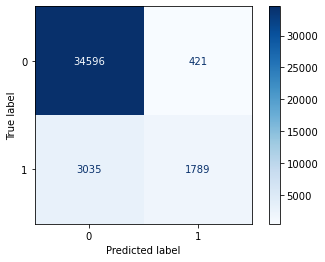

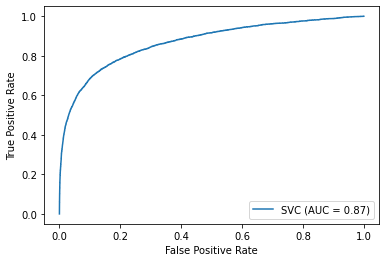

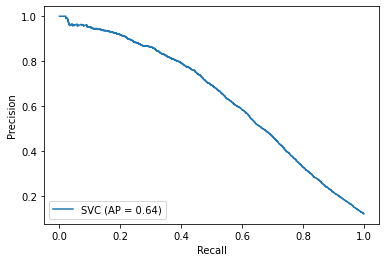

In [17]:
be_preds = be.predict(X_test_transformed)
#be_probs = be.predict_proba(X_test_transformed)[:,1]

print(classification_report(y_test, be_preds))

plot_confusion_matrix(be, X_test_transformed, y_test, cmap = plt.cm.Blues)
plt.show()

plot_roc_curve(be, X_test_transformed, y_test)
plt.show()

plot_precision_recall_curve(be, X_test_transformed, y_test)
plt.show()

In [20]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, be_preds)
metrics.auc(fpr, tpr)


0.6794156656011335

### Feature Ranking (for logistic regression)

In [3]:
vocab = vectorizer.get_feature_names()
coef_dicts = []
for i, coef_ in enumerate(list(be.coef_[0,:])):
    coef_dict = {'word': vocab[i], 'coef': coef_}
    coef_dicts.append(coef_dict)

coef_pd = pd.DataFrame(coef_dicts)
print("Words with Lowest Coefficients of Logistic Regression model")
print(coef_pd.sort_values('coef', ascending=True)[['word', 'coef']][:20])

print("Words with Highest Coefficients of Logistic Regression model")
print(coef_pd.sort_values('coef', ascending=False)[['word', 'coef']][:20])

### Feature Ranking (for bernoulli nb)

In [ ]:
neg_class_prob_sorted = be.feature_logprob[0, :].argsort()
pos_class_prob_sorted = be.feature_logprob[1, :].argsort()

neg_pd = pd.DataFrame({'word': np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[:20])}, 
                       index = neg_class_prob_sorted[:20])

pos_pd = pd.DataFrame({'word': np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[:20])}, 
                       index = pos_class_prob_sorted[:20])

print("Words Ranking for the Non-Satirical Class of Bernoulli NB CV model")
print(neg_pd)
print()
print("Words Ranking for the Satirical Class of Bernoulli NB CV model")
print(pos_pd)

## Save Information

In [20]:
logging.info(grid_search.cv_results_)

In [21]:
auc_score = roc_auc_score(y_test, be_probs)
avg_precision = average_precision_score(y_test, be_probs)
cm = confusion_matrix(y_test, be_preds)

In [22]:
logging.info(f'AUC: {auc_score}')
logging.info(f'Average Precision: {avg_precision}')
logging.info('Confusion Matrix:')
logging.info(cm)
logging.info("Classification Report:")
logging.info(classification_report(y_test, be_preds))